In [6]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import joblib
import nltk
from nltk.corpus import stopwords
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
csv_path = "Datasets/spam.csv"  

df = pd.read_csv(csv_path , encoding="latin1",)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

assert {"v1", "v2"}.issubset(df.columns), "CSV'de 'category' ve 'sentences' sütunları olmalı!"

df = df.dropna(subset=["v1", "v2"]).reset_index(drop=True)

print(df.head())
print(df["v1"].value_counts())

# temizlenmiş dataframe'i kaydet
df.to_csv("Datasets/spam_clean.csv", index=False, encoding="utf-8")

     v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
v1
ham     4825
spam     747
Name: count, dtype: int64


In [18]:
#Cleaning Processes

df = pd.read_csv("Datasets/spam_clean.csv", encoding="latin1")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

TEXT_CANDIDATES = ["message","messages","text","sms","sentence","sentences","v2","body","content"]
CAT_CANDIDATES  = ["category","label","class","target","v1","type"]

def pick_col(cands, cols):
    for c in cands:
        if c in cols:
            return c
            
    for c in cols:
        if pd.api.types.is_string_dtype(df[c]):
            return c
    raise ValueError("Metin kolonu bulunamadı. Lütfen text kolonu adını kontrol et.")

text_col = pick_col(TEXT_CANDIDATES, list(df.columns))

cat_col  = None
for c in CAT_CANDIDATES:
    if c in df.columns:
        cat_col = c
        break

print(f"📝 Metin kolonu: {text_col}" + (f" | 🏷️ Kategori kolonu: {cat_col}" if cat_col else ""))

URL_RE    = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)
EMAIL_RE  = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")
PHONE_RE  = re.compile(r"\b(?:\+?\d{1,3}[\s-]?)?(?:\(?\d{3}\)?[\s-]?)?\d{3}[\s-]?\d{4}\b")
WS_RE     = re.compile(r"\s+")

PUNCT_RE  = re.compile(r"[^0-9a-zA-ZçğıöşüÇĞİÖŞÜ\s]")

def clean_text(s: str, keep_digits=True):
    if pd.isna(s):
        return ""
    s = str(s).strip().lower()
    s = URL_RE.sub(" ", s)
    s = EMAIL_RE.sub(" ", s)
    s = PHONE_RE.sub(" ", s)
    # sembolleri sil
    if keep_digits:
        s = PUNCT_RE.sub(" ", s)   # sayıları korur
    else:
        s = re.sub(r"[^a-zA-ZçğıöşüÇĞİÖŞÜ\s]", " ", s)
    s = WS_RE.sub(" ", s).strip()
    return s

df["v3_cleaned"] = df[text_col].apply(clean_text)

print(df[[text_col, "v3_cleaned"]].head())

df.to_csv("Datasets/spam_clean_ready.csv", index=False, encoding="latin1")
print("✅ Temizlenmiş veri 'spam_clean_ready.csv' olarak kaydedildi.")

📝 Metin kolonu: v2 | 🏷️ Kategori kolonu: v1
                                                  v2  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                          v3_cleaned  
0  go until jurong point crazy available only in ...  
1                            ok lar joking wif u oni  
2  free entry in 2 a wkly comp to win fa cup fina...  
3        u dun say so early hor u c already then say  
4  nah i don t think he goes to usf he lives arou...  
✅ Temizlenmiş veri 'spam_clean_ready.csv' olarak kaydedildi.


In [20]:
# Stopwords removal!!!
stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

# New Column for removed stopwords
df["key_column"] = df["v3_cleaned"].apply(remove_stopwords)
df.to_csv("Datasets/spam_clean_removed_stopwords.csv", index=False, encoding="latin1")
print(df[["v3_cleaned", "key_column"]].head())

                                          v3_cleaned  \
0  go until jurong point crazy available only in ...   
1                            ok lar joking wif u oni   
2  free entry in 2 a wkly comp to win fa cup fina...   
3        u dun say so early hor u c already then say   
4  nah i don t think he goes to usf he lives arou...   

                                          key_column  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry 2 wkly comp win fa cup final tkts 2...  
3                u dun say early hor u c already say  
4             nah think goes usf lives around though  


📝 text: v3_cleaned | 🏷️ label: v1
✅ Accuracy: 0.9713
              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       966
        spam       0.86      0.94      0.90       149

    accuracy                           0.97      1115
   macro avg       0.92      0.96      0.94      1115
weighted avg       0.97      0.97      0.97      1115

📊 Confusion Matrix:
 [[943  23]
 [  9 140]]


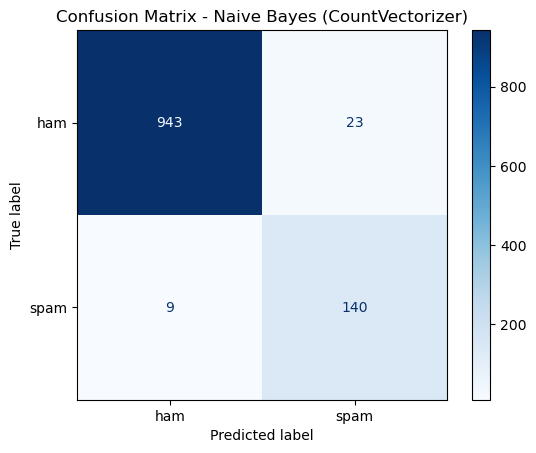

In [10]:
# Without stopwords removal CountVector

df = pd.read_csv("Datasets/spam_clean_ready.csv", encoding="latin1")

TEXT_CANDS = ["v3_cleaned"]
LABEL_CANDS = ["v1"]

text_col = next(c for c in TEXT_CANDS if c in df.columns)
y_col    = next(c for c in LABEL_CANDS if c in df.columns)

print(f"📝 text: {text_col} | 🏷️ label: {y_col}")

if df[y_col].dtype == "O":
    df[y_col] = df[y_col].str.strip().str.lower().map({"ham": 0, "spam": 1}).fillna(df[y_col])

X_text = df[text_col].astype(str)
y = df[y_col].astype(int)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

# 4) CountVectorizer 
vect = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    max_features=50000
)

Xtr = vect.fit_transform(X_tr)
Xte = vect.transform(X_te)

# Class imbalance
sample_w = compute_sample_weight(class_weight="balanced", y=y_tr)

clf = MultinomialNB()
clf.fit(Xtr, y_tr, sample_weight=sample_w)

pred = clf.predict(Xte)
print("✅ Accuracy:", round(accuracy_score(y_te, pred), 4))
print(classification_report(y_te, pred, target_names=["ham", "spam"]))

cm = confusion_matrix(y_te, pred)
print("📊 Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham", "spam"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Naive Bayes (CountVectorizer)")
plt.show()

📝 text: key_column | 🏷️ label: v1
✅ Accuracy: 0.9704
              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       966
        spam       0.86      0.93      0.89       149

    accuracy                           0.97      1115
   macro avg       0.92      0.95      0.94      1115
weighted avg       0.97      0.97      0.97      1115

📊 Confusion Matrix:
 [[943  23]
 [ 10 139]]


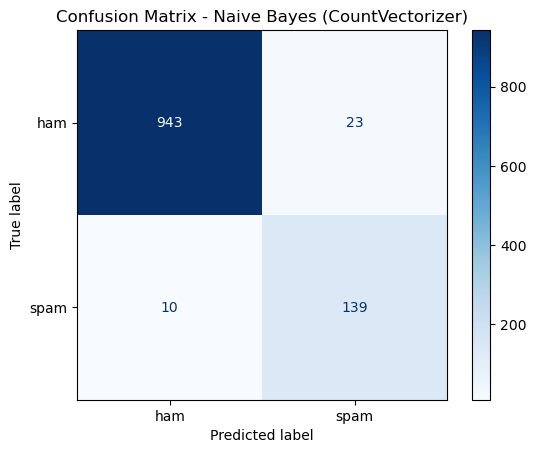

In [8]:
# With stopwords removal CountVector

df = pd.read_csv("Datasets/spam_clean_removed_stopwords.csv", encoding="latin1")

TEXT_CANDS = ["key_column"]
LABEL_CANDS = ["v1"]

text_col = next(c for c in TEXT_CANDS if c in df.columns)
y_col    = next(c for c in LABEL_CANDS if c in df.columns)

print(f"📝 text: {text_col} | 🏷️ label: {y_col}")

if df[y_col].dtype == "O":
    df[y_col] = df[y_col].str.strip().str.lower().map({"ham": 0, "spam": 1}).fillna(df[y_col])

X_text = df[text_col].astype(str)
y = df[y_col].astype(int)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

# 4) CountVectorizer 
vect = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    max_features=50000
)

Xtr = vect.fit_transform(X_tr)
Xte = vect.transform(X_te)

# Class imbalance
sample_w = compute_sample_weight(class_weight="balanced", y=y_tr)

clf = MultinomialNB()
clf.fit(Xtr, y_tr, sample_weight=sample_w)

pred = clf.predict(Xte)
print("✅ Accuracy:", round(accuracy_score(y_te, pred), 4))
print(classification_report(y_te, pred, target_names=["ham", "spam"]))

cm = confusion_matrix(y_te, pred)
print("📊 Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham", "spam"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Naive Bayes (CountVectorizer)")
plt.show()